In [1]:
!pip install tf-nightly==2.3.0-dev20200611

  Using cached tf_nightly-2.3.0.dev20200611-cp36-cp36m-manylinux2010_x86_64.whl (349.8 MB)
  Using cached tb_nightly-2.3.0a20200722-py3-none-any.whl (6.8 MB)
ERROR: tf-nightly-gpu 2.4.0.dev20200913 has requirement tb-nightly<3.0.0a0,>=2.4.0a0, but you'll have tb-nightly 2.3.0a20200722 which is incompatible.
  Attempting uninstall: tb-nightly
    Found existing installation: tb-nightly 2.4.0a20200913
    Uninstalling tb-nightly-2.4.0a20200913:
      Successfully uninstalled tb-nightly-2.4.0a20200913
  Attempting uninstall: tf-nightly
    Found existing installation: tf-nightly 2.4.0.dev20200913
    Uninstalling tf-nightly-2.4.0.dev20200913:
      Successfully uninstalled tf-nightly-2.4.0.dev20200913


In [27]:
!pip install wordcloud

     |████████████████████████████████| 365 kB 15.8 MB/s eta 0:00:01


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from wordcloud import WordCloud
tf.__version__

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'2.3.0-dev20200611'

In [2]:
data = pd.read_csv("./amazon_review_full_csv/train.csv", names=["rating", "title", "text"])
test_data = pd.read_csv("./amazon_review_full_csv/test.csv", names=["rating", "title", "text"])

# Drop rows where rating == 3
data = data.drop(data[data["rating"]==3].index)
test_data = test_data.drop(test_data[test_data["rating"]==3].index)
print(data.head(5))

# Map rating to sentiment target (1=positiv)
data["sentiment"] = np.where(data["rating"]>=4, 1, 0)
test_data["sentiment"] = np.where(test_data["rating"]>=4, 1, 0)

# Drop columns to make the data structure just text and target sentiment
data.drop(columns=["rating", "title"], inplace=True)
test_data.drop(columns=["rating", "title"], inplace=True)

# split 80:20 train:validation set
train, val = train_test_split(data, test_size=0.2, random_state=88)

print(data.head(5))

   rating                                  title  \
1       5                              Inspiring   
2       5  The best soundtrack ever to anything.   
3       4                       Chrono Cross OST   
4       5                    Too good to be true   
5       5         There's a reason for the price   

                                                text  
1  I hope a lot of people hear this cd. We need m...  
2  I'm reading a lot of reviews saying that this ...  
3  The music of Yasunori Misuda is without questi...  
4  Probably the greatest soundtrack in history! U...  
5  There's a reason this CD is so expensive, even...  
                                                text  sentiment
1  I hope a lot of people hear this cd. We need m...          1
2  I'm reading a lot of reviews saying that this ...          1
3  The music of Yasunori Misuda is without questi...          1
4  Probably the greatest soundtrack in history! U...          1
5  There's a reason this CD is so exp

In [3]:
batch_size = 64

# Turn pandas dataframe to tensor dataset
data_raw = tf.data.Dataset.from_tensor_slices((data["text"], data["sentiment"]))
train_raw = tf.data.Dataset.from_tensor_slices((train["text"], train["sentiment"]))
val_raw = tf.data.Dataset.from_tensor_slices((val["text"], val["sentiment"]))
test_raw = tf.data.Dataset.from_tensor_slices((test_data["text"], test_data["sentiment"]))
print(train_raw)

# Batch
data_raw = data_raw.batch(batch_size)
train_raw = train_raw.batch(batch_size)
val_raw = val_raw.batch(batch_size)
test_raw = test_raw.batch(batch_size)
print(train_raw)

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int64)>
<BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>


In [4]:
for text_batch, label_batch in train_raw.take(2):
  for i in range(2):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b"All I can say is that I have loved this album since it came out. Great for when you're in or out of love."
Label 1
Review b"I was expecting a cheap wig when you pay 8 dollars for a wig you don't expect anything high class however I have found some decent wigs that are cheap. This is not one of them the wig was frizzed out and had static to the point I couldn't touch it unless I wanted half the wig to come off with my gloves, just plain nylon gloves mind you. never getting this again"
Label 0
Review b'This reader DELETES the files instead of DISPLAYING them on Mac OS X (Snow Leopard and Lion). The hardware seems OK, but I guess the firmware (at least for Mac) is incompatible. -- written in July 2012'
Label 0
Review b"Don't let this book fool you ... it's not just for romantic couples but everyone in a relationship to their family, friends, and colleagues. Grayson has lots of action-oriented excercises to help readers get the personal experience of the techniques he advocates. S

In [5]:
# Data cleaning/ preprocessing
# 1. Change to lowercase, 2. Remove "\n", 3. Remove stop words, 4. Remove punctuation
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped = tf.strings.regex_replace(lowercase, '\n', ' ')
    pattern = r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*'
    text = tf.strings.regex_replace(stripped, pattern, '')
    return tf.strings.regex_replace(text,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

# Standardize, tokenize, vectorize
# Define constants
max_features = 10000
# Cause the layer to pad or truncate sequences to exactly sequence_length values.
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only training data (without labels), then call adapt
train_text = data_raw.map(lambda x, y: x)
print(train_text)
vectorize_layer.adapt(train_text)

<MapDataset shapes: (None,), types: tf.string>


In [6]:
# Vectorization text function
def vectorize_text(text, label):
    text = tf.convert_to_tensor(text)
    #change shape of text from () to (1,)
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [7]:
# # Lookup the token (string) that each integer corresponds to by calling .get_vocabulary() on the layer.
# print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
# print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
# print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

In [11]:
# Create our model

# Dimension of dense embedding
embedding_dim = 16

# A text input.
text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')

# The first layer in our model is the vectorization layer. After this layer,
# we have a tensor of shape (batch_size, max_len) containing vocab indices.
x = vectorize_layer(text_input)

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'. Note that we're using max_features+1 here, since there's an
# OOV token that gets added to the vocabulary in vectorize_layer.
x = layers.Embedding(max_features + 1, embedding_dim)(x)
x = layers.Dropout(0.2)(x)

# global max pooling
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.2)(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)

model = tf.keras.Model(text_input, predictions)

model.summary()

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(
    loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 250)               0         
_________________________________________________________________
embedding (Embedding)        (None, 250, 16)           160016    
_________________________________________________________________
dropout (Dropout)            (None, 250, 16)           0         
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 128)              

In [12]:
# Regularization by early stopping ie. stop training once val_loss increases
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [14]:
print(train_raw)
print(val_raw)

<BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>
<BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>


In [15]:
# Model that includes vectorize_layer already

# Train model
epochs = 10
history = model.fit(
    train_raw,
    validation_data=val_raw,
    epochs=epochs,
    callbacks=[es])

Epoch 1/10
30000/30000 [==============================] - 224s 7ms/step - loss: 0.4233 - accuracy: 0.8051 - val_loss: 0.3917 - val_accuracy: 0.8297
Epoch 2/10
30000/30000 [==============================] - 224s 7ms/step - loss: 0.4126 - accuracy: 0.8117 - val_loss: 0.3923 - val_accuracy: 0.8301
Epoch 3/10
30000/30000 [==============================] - 223s 7ms/step - loss: 0.4117 - accuracy: 0.8124 - val_loss: 0.3897 - val_accuracy: 0.8295
Epoch 4/10
30000/30000 [==============================] - 224s 7ms/step - loss: 0.4117 - accuracy: 0.8123 - val_loss: 0.3883 - val_accuracy: 0.8298
Epoch 5/10
30000/30000 [==============================] - 225s 7ms/step - loss: 0.4117 - accuracy: 0.8122 - val_loss: 0.3880 - val_accuracy: 0.8296
Epoch 6/10
30000/30000 [==============================] - 225s 8ms/step - loss: 0.4116 - accuracy: 0.8120 - val_loss: 0.3911 - val_accuracy: 0.8299
Epoch 7/10
30000/30000 [==============================] - 225s 8ms/step - loss: 0.4116 - accuracy: 0.8124 - val_

In [18]:
# Evaluate model with test set

loss, accuracy = model.evaluate(test_raw)
print(accuracy)

8125/8125 [==============================] - 38s 5ms/step - loss: 0.3877 - accuracy: 0.8308
0.8307711482048035


In [19]:
# Save model
model.save("export_model_v7.tf")

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: export_model_v7.tf/assets


In [20]:
loaded_model = keras.models.load_model('./export_model_v7.tf')

In [22]:
# Inference - predict probability of a string being positive
single_x_test = "amazing product, will buy again"
q = loaded_model.predict(np.array([single_x_test,]))[0]
print(q)

[0.88524806]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


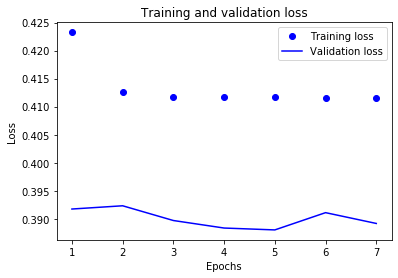

In [23]:

history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Plot loss over time graph

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

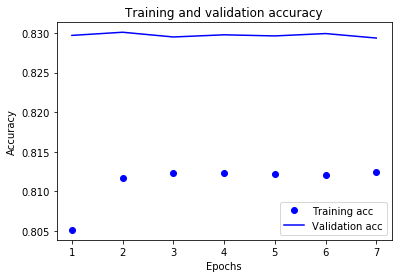

In [24]:
# Plot accuracy over time graph
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [43]:
positive_data = train.loc[train["sentiment"]==1, "text"]
negative_data = train.loc[train["sentiment"]==0, "text"]
print(negative_data.head(5))

916397     I was expecting a cheap wig when you pay 8 dol...
2854799    This is more than a pain to put together.It re...
1066852    The manufacturer fails to mention that the str...
2237293    This movie had a VERY good plot. The actors/ac...
1492718    A more apt title would be "The Theory Of Runni...
Name: text, dtype: object


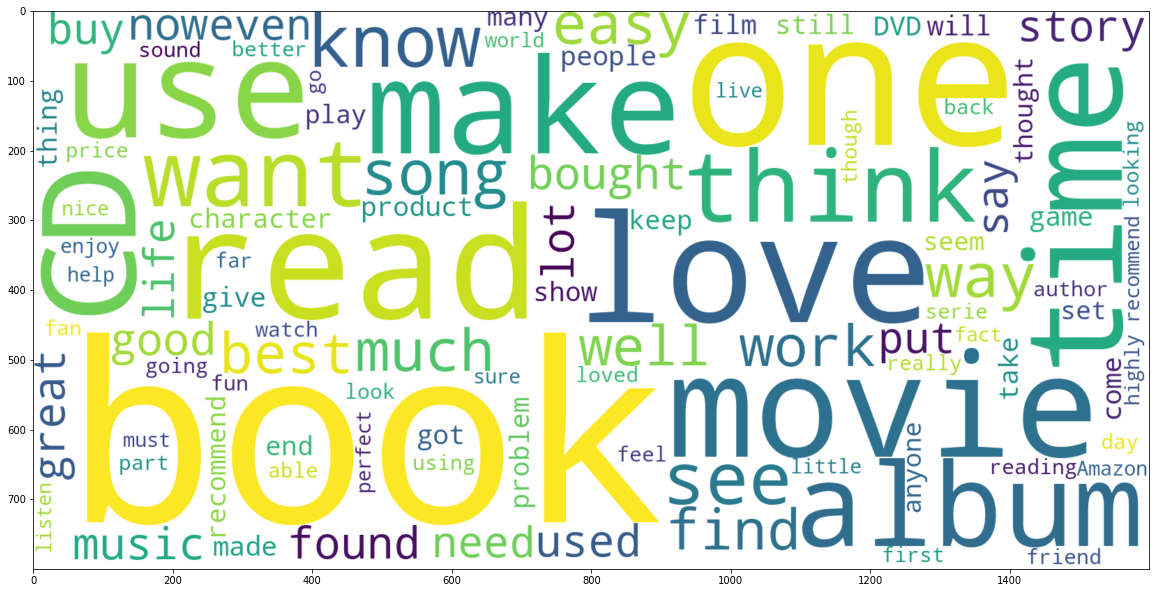

In [41]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(min_font_size=10,  max_words=100 , width=1600 , height=800, background_color="white").generate(" ".join(positive_data))
plt.imshow(wc,interpolation = 'bilinear')

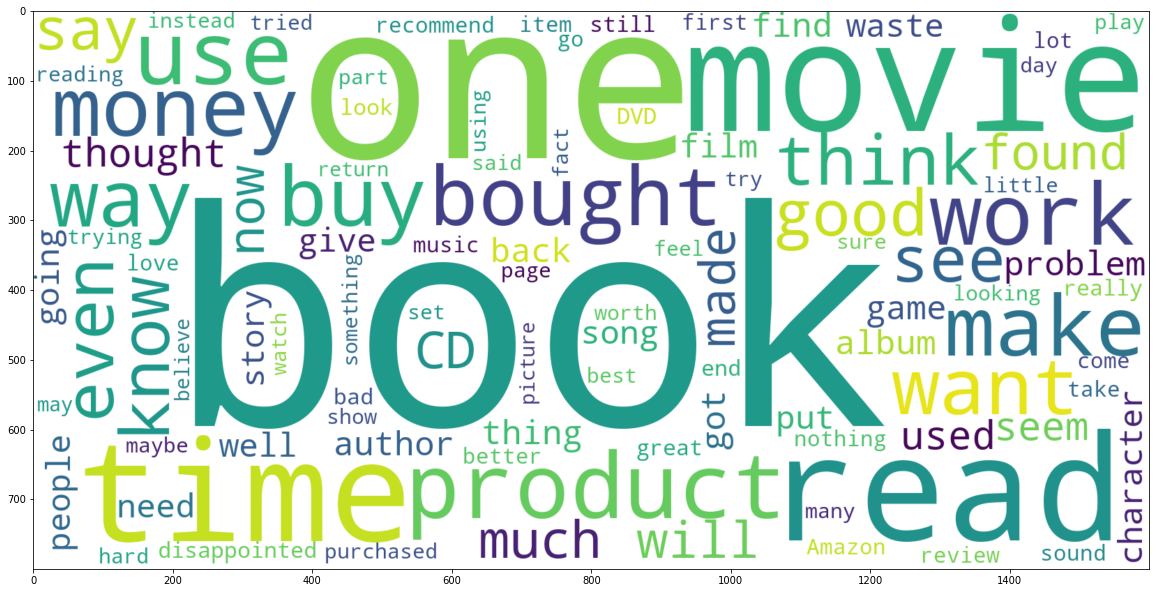

In [44]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(min_font_size=10,  max_words=100 , width=1600 , height=800, background_color="white").generate(" ".join(negative_data))
plt.imshow(wc,interpolation = 'bilinear')